## Start by setting seeds to get reproduceable results


In [1]:
import numpy as np
import tensorflow as tf
import keras
import random

seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
keras.utils.set_random_seed(seed)

## Define functions for plotting

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_comparison(model, val_data, val_labels, times=[60, 70, 80, 90, 99], save_path='plots/comparison_plot.png'):
    dir_path = os.path.dirname(save_path)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    # Pick a random sample from the validation set
    sample_index = np.random.randint(0, val_data.shape[0])
    input_sample = np.expand_dims(val_data[sample_index], axis=0)  # Expand dims to match model input requirements
    predicted_output = model.predict(input_sample) 
    predicted_output = predicted_output.reshape(val_labels.shape[1:])  # Reshape prediction to match label dimensions
    
    actual_output = val_labels[sample_index]

    # Adjust time indices for plotting relative to validation label indices
    relative_times = [time - 60 for time in times]  # Adjust to index from 0 to 39

    # Set up the figure and axes
    fig, axes = plt.subplots(2, len(times), figsize=(20, 10))

    # Adding overarching titles for clarity
    fig.suptitle('Comparison of Target and Predicted Outputs', fontsize=16)
    fig.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel('Time steps', fontsize=14)
    plt.ylabel('Output Type', fontsize=14, labelpad=20)
    
    for i, time in enumerate(relative_times):
        # Plot actual data
        ax_actual = axes[0, i]
        ax_actual.imshow(actual_output[time], cmap='hot', interpolation='nearest')
        ax_actual.set_title(f'Time step {times[i]}')
        ax_actual.set_xticks([])  
        ax_actual.set_yticks([])  
      
        # Plot predicted data
        ax_pred = axes[1, i]
        ax_pred.imshow(predicted_output[time], cmap='hot', interpolation='nearest')
        ax_pred.set_xticks([]) 
        ax_pred.set_yticks([]) 



    # Set row titles more visibly
    axes[0, 0].set_ylabel('Target', fontsize=14, labelpad=10)
    axes[1, 0].set_ylabel('Predicted', fontsize=14, labelpad=10)

    plt.tight_layout()

    plt.show()

In [3]:
import imageio.v2 as imageio
import io
from IPython.display import Image, display 

def plot_comparison_as_gifs(model, val_data, val_labels, save_dir='gifs'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Pick a random sample from the validation set
    sample_index = np.random.randint(0, val_data.shape[0])
    input_sample = np.expand_dims(val_data[sample_index], axis=0)  # Expand dims to match model input requirements
    predicted_output = model.predict(input_sample)  
    predicted_output = predicted_output.reshape(val_labels.shape[1:])  # Reshape prediction to match label dimensions

    actual_output = val_labels[sample_index]

    images = []  # List to hold all the frames for the GIF
    for time_step in range(actual_output.shape[0]):
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # One row, two columns for actual and predicted

        # Display actual data
        axes[0].imshow(actual_output[time_step].squeeze(), cmap='hot', interpolation='nearest')
        axes[0].set_title('Actual Data')
        axes[0].axis('off')

        # Display predicted data
        axes[1].imshow(predicted_output[time_step].squeeze(), cmap='hot', interpolation='nearest')
        axes[1].set_title('Predicted Data')
        axes[1].axis('off')

        # Save the plot to a temporary buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        plt.close(fig)
        buf.seek(0)
        image = imageio.imread(buf)
        images.append(image)
        buf.close()

    # Save the images as a GIF
    gif_path = os.path.join(save_dir, f'comparison_{sample_index}.gif')
    imageio.mimsave(gif_path, images, duration=0.3, loop=0)

    # Display the GIF in the Jupyter notebook
    display(Image(filename=gif_path))



In [4]:
def plot_history(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.show()

In [5]:
def plot_model_comparison(fcnn_history, cnn_history, picnn_history, cnn_observation_bias_history):
    plt.figure(figsize=(8, 5))
    plt.plot(fcnn_history.history['val_loss'], label=f'Simple FCNN')
    plt.plot(cnn_history.history['val_loss'], label=f'CNN')
    plt.plot(picnn_history.history['val_mse_metric'], label=f'CNN + Physics Loss')
    plt.plot(cnn_observation_bias_history.history['val_loss'], label=f'CNN + Observation bias')
    plt.title('Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.show()

## Load the data

80/20 split already done during data generation

In [6]:
# Load the data from the saved file
def load_data(filename):
    with np.load(filename) as data:
        return data['data'], data['alphas'], data['source_positions']

train_data, train_alphas, train_source_positions = load_data('heat_diffusion_train_data_noisy.npz')
train_data = train_data.reshape(train_data.shape + (1,))

val_data, val_alphas, val_source_positions = load_data('heat_diffusion_val_data_noisy.npz') 
val_data = val_data.reshape(val_data.shape + (1,))

## Split data into input and target
Give 60 timesteps as input, predict the following 40 timesteps


In [7]:
train_labels = train_data[:, 60:]
train_data = train_data[:, :60]

val_labels = val_data[:, 60:]
val_data = val_data[:, :60]

input_shape = train_data.shape[1:]  # 60 timesteps of 32x32 grid 100 x 60 x 32 x 32 x 1
output_shape = train_labels.shape[1:]  # 40 timesteps of 32x32 grid

print(f"Shapes: (num_samples, timesteps, width, height, channels)")
print(f"Training data shape:   {train_data.shape}")
print(f"Testing data shape:    {val_data.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Testing labels shape:  {val_labels.shape}")

n_epochs = 30

Shapes: (num_samples, timesteps, width, height, channels)
Training data shape:   (80, 60, 32, 32, 1)
Testing data shape:    (20, 60, 32, 32, 1)
Training labels shape: (80, 40, 32, 32, 1)
Testing labels shape:  (20, 40, 32, 32, 1)


## Initial setup: simple fully connected NN

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Reshape

def build_fcnn(input_shape, output_shape):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(np.prod(output_shape), activation='linear'),
        Reshape(output_shape)  
    ])
    return model

In [9]:
fcnn_model = build_fcnn(input_shape, output_shape)
fcnn_model.summary()
fcnn_model.compile(optimizer='adam', loss='mse')
fcnn_history = fcnn_model.fit(train_data, train_labels, epochs=n_epochs, validation_data=(val_data, val_labels))


c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 61440)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,864,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 40960)          │     5,283,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 40, 32, 32, 1)  │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,164,800 (50.22 MB)

 Trainable params: 13,164,800 (50.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0276 - val_loss: 0.0255
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0231 - val_loss: 0.0220
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0176 - val_loss: 0.0207
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0134 - val_loss: 0.0192
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0103 - val_loss: 0.0183
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0080 - val_loss: 0.0172
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0064 - val_loss: 0.0161
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0053 - val_loss: 0.0162
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0046 - val_loss: 0.0154
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0041 - val_loss: 0.0156
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0035 - val_loss: 0.0150
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0030 - val_loss: 0.0149


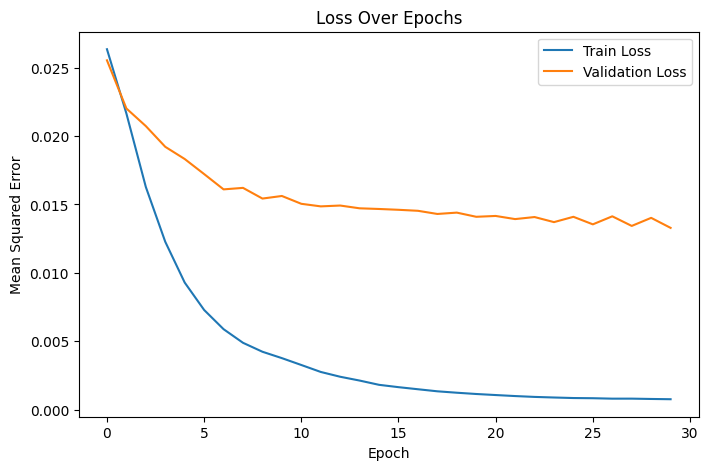

In [10]:
plot_history(fcnn_history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


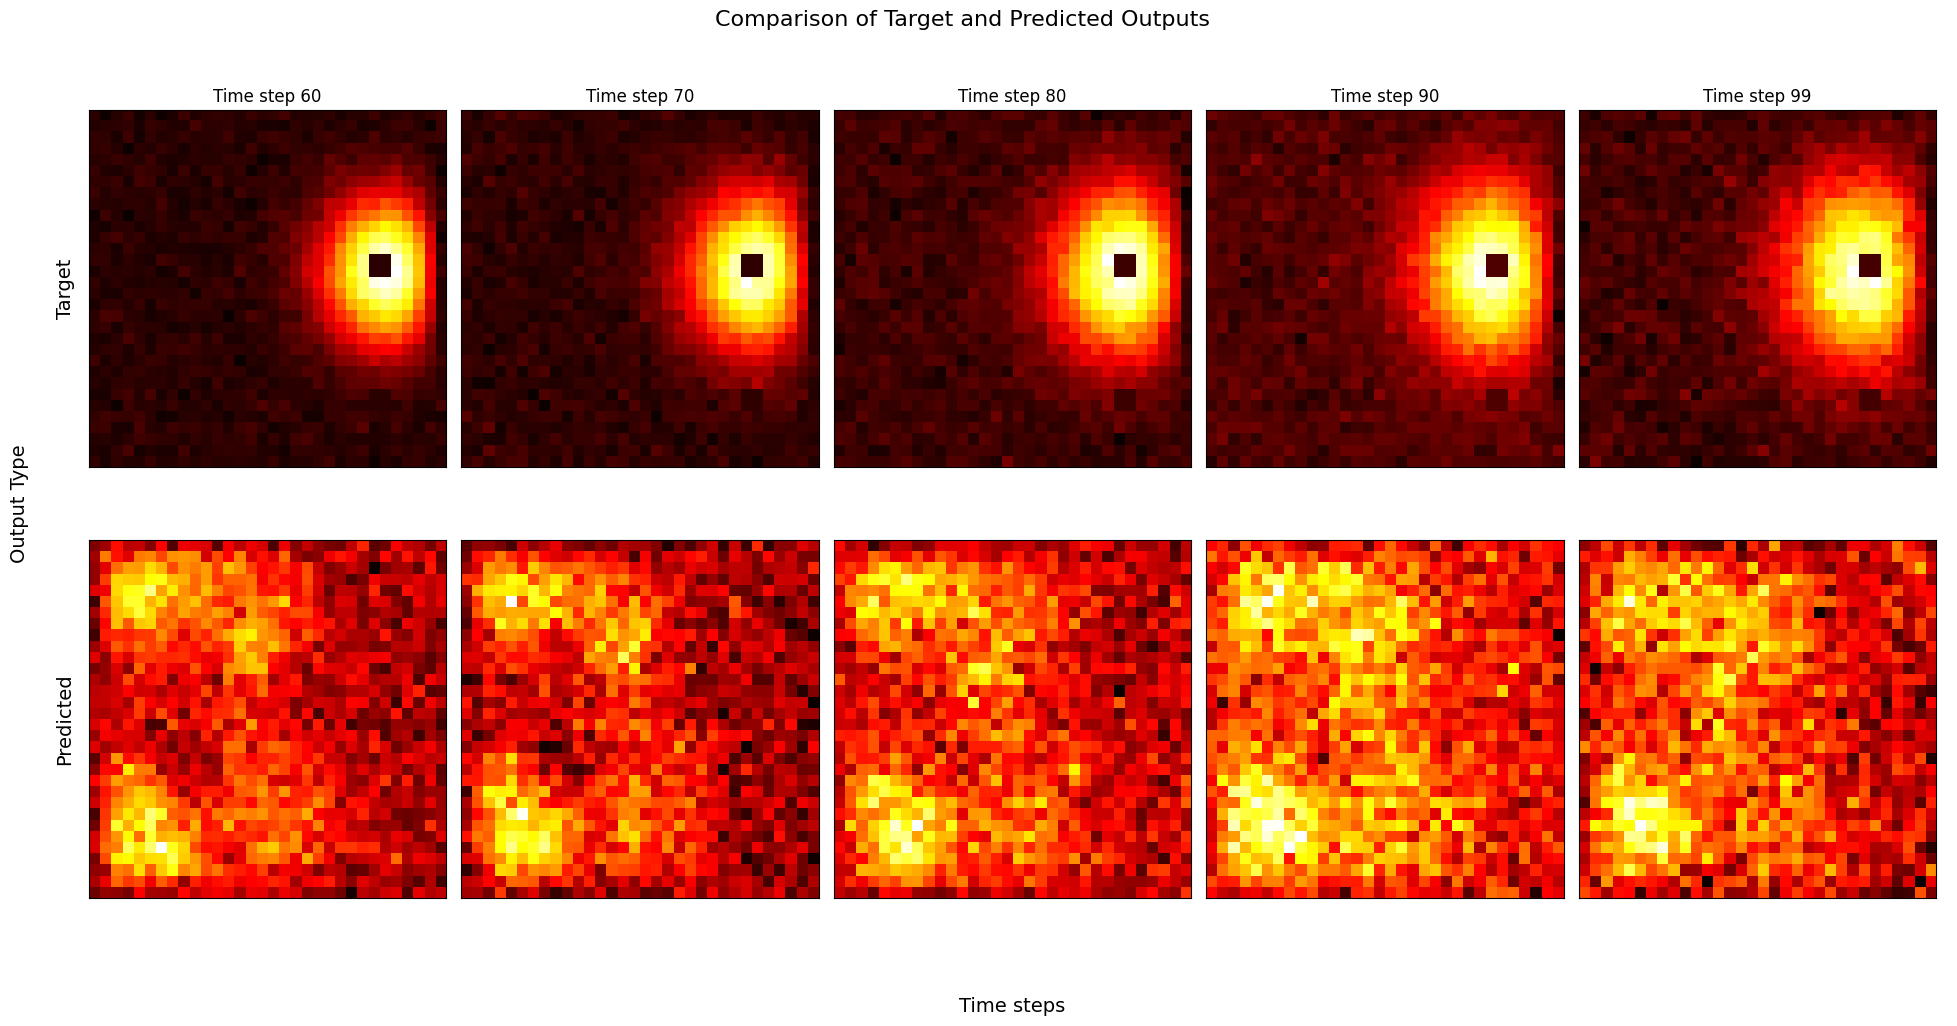

In [35]:
plot_comparison(fcnn_model, val_data, val_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


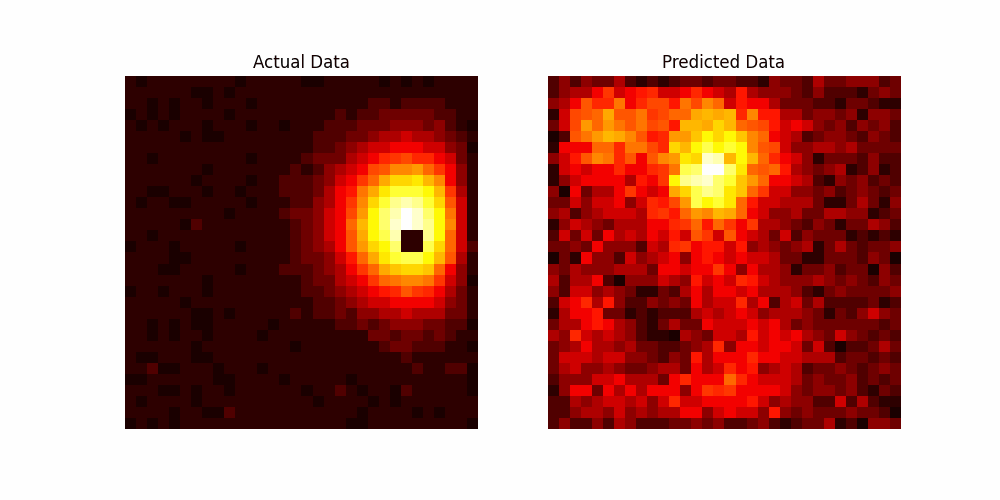

In [12]:
plot_comparison_as_gifs(fcnn_model, val_data, val_labels, save_dir='gifs/fcnn')

## Improvement 1: add inductive bias -> CNN

In [13]:
from keras.layers import Conv3D, InputLayer

def build_cnn(input_shape, output_shape):
    model = Sequential([
        InputLayer(input_shape=input_shape),
    
        Conv3D(16, kernel_size=(2, 2, 2), activation='relu', padding="same", strides=(1, 1, 1)),
        Conv3D(16, kernel_size=(2, 2, 2), activation='relu', padding='same', strides=(1, 1, 1)),
        
        Conv3D(1, kernel_size=(21, 1, 1), activation='linear', padding='valid', strides=(1, 1, 1))
    ])
    return model

In [14]:
cnn_model = build_cnn(input_shape, output_shape)
cnn_model.summary()
cnn_model.compile(optimizer='adam', loss='mse')
cnn_history = cnn_model.fit(train_data, train_labels, epochs=n_epochs, validation_data=(val_data, val_labels))

c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 60, 32, 32, 16) │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 60, 32, 32, 16) │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 40, 32, 32, 1)  │           337 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,545 (9.94 KB)

 Trainable params: 2,545 (9.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - loss: 0.0206 - val_loss: 0.0161
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - loss: 0.0164 - val_loss: 0.0127
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.0137 - val_loss: 0.0108
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - loss: 0.0120 - val_loss: 0.0093
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.0105 - val_loss: 0.0080
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.0091 - val_loss: 0.0072
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - loss: 0.0081 - val_loss: 0.0065
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0073 - val_loss: 0.0058
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - loss: 0.0065 - val_loss: 0.0051
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - loss: 0.0058 - val_loss: 0.0046
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - loss: 0.0051 - val_loss: 0.0041
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0046 - val_lo

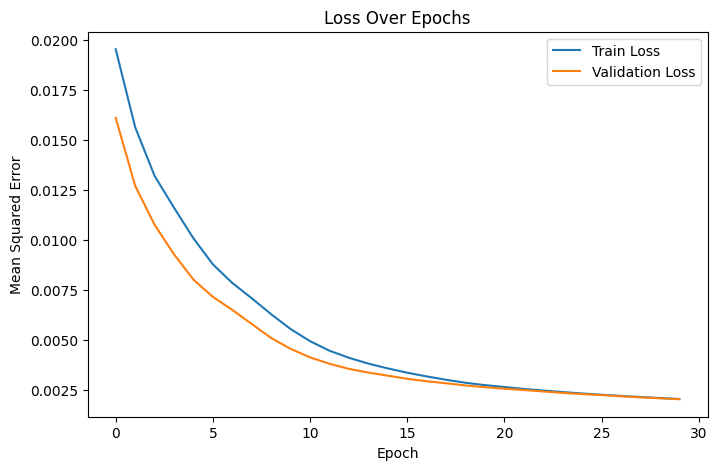

In [15]:
plot_history(cnn_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


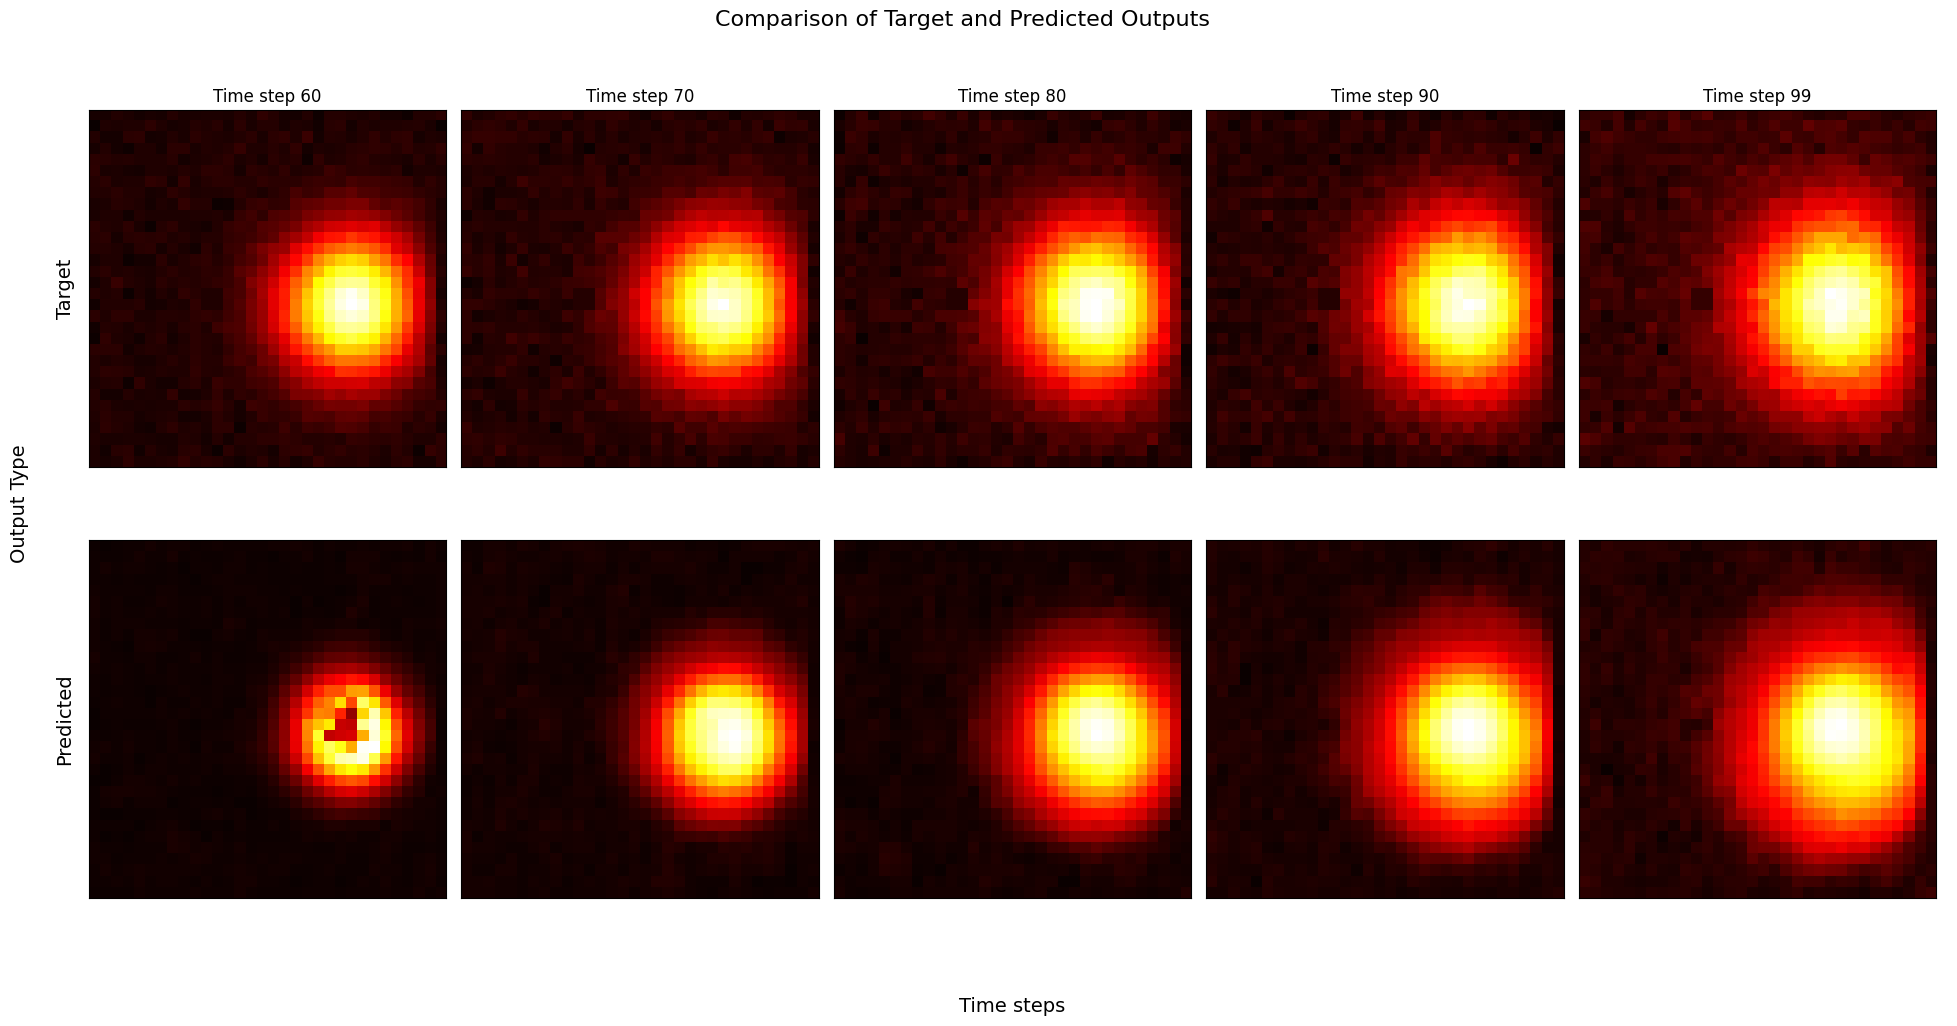

In [16]:
plot_comparison(cnn_model, val_data, val_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


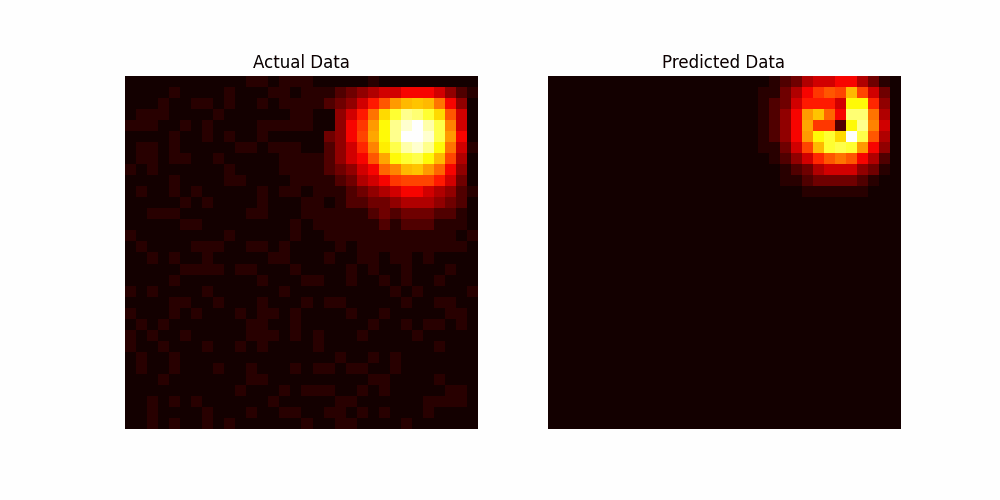

In [17]:
plot_comparison_as_gifs(cnn_model, val_data, val_labels)

## Improvement 2: add learning bias -> heat diffusion equation

The heat diffusion equation, commonly known as the heat equation, is expressed in the form:

$$
\frac{\partial u}{\partial t} = \alpha \nabla^2 u
$$

Where 
- u is the temperature
- $\alpha$ is the diffusion coefficient
- $\nabla^2 u$ is the Lapacian

-> use finite difference approximation of Laplacian


In [18]:

def calculate_laplacian(y_pred):
    center = y_pred[:, :, 1:-1, 1:-1]
    top = y_pred[:, :, :-2, 1:-1]
    bot = y_pred[:, :, 2:, 1:-1]
    left = y_pred[:, :, 1:-1, :-2]
    right = y_pred[:, :, 1:-1, 2:]

    discrete_laplacian = top + bot + left + right - 4 * center
    return discrete_laplacian

def boundary_condition_loss(y_pred):
    # Extract the boundary values
    top_edge = y_pred[:, :, 0, :]
    bottom_edge = y_pred[:, :, -1, :]
    left_edge = y_pred[:, :, :, 0]
    right_edge = y_pred[:, :, :, -1]

    # Calculate the mean squared error against zero
    boundary_loss = tf.reduce_mean(tf.square(top_edge)) + \
                    tf.reduce_mean(tf.square(bottom_edge)) + \
                    tf.reduce_mean(tf.square(left_edge)) + \
                    tf.reduce_mean(tf.square(right_edge))
    return boundary_loss

def physics_informed_loss(w_l = 1., w_p = 1., w_b = 1.0):
    def loss(y_true, y_pred):

        # MSE Loss
        mse = tf.reduce_mean(tf.square(y_true - y_pred))

        # Physics-based Loss
        # Extract necessary slices from y_pred for central, north, south, east, and west points
        discrete_laplacian = calculate_laplacian(y_pred)
        
        # assuming a fixed alpha over a single time step
        physics_loss = tf.reduce_mean(tf.square(discrete_laplacian))
        
         # Boundary condition loss
        boundary_loss = boundary_condition_loss(y_pred)

        # Combined Loss
        total_loss = w_l * mse + w_p * physics_loss + w_b * boundary_loss

        return total_loss

    return loss


In [19]:
class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("\nEpoch: {}, MSE: {:.4f}, Physics Loss: {:.4f}".format(epoch, logs['mse_metric'], logs['physics_loss_metric']))


def mse_metric(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def physics_loss_metric(y_true, y_pred):
    discrete_laplacian = calculate_laplacian(y_pred)
    return tf.reduce_mean(tf.square(discrete_laplacian))



In [20]:
picnn_model = build_cnn(input_shape, output_shape)
picnn_model.compile(optimizer='adam', loss=physics_informed_loss(w_l=2., w_p=1., w_b = 1.), metrics=[mse_metric, physics_loss_metric])
picnn_history = picnn_model.fit(train_data, train_labels, epochs=n_epochs, validation_data=(val_data, val_labels), callbacks=[LossAndErrorPrintingCallback()])

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 0.0537 - mse_metric: 0.0243 - physics_loss_metric: 0.0047
Epoch: 0, MSE: 0.0209, Physics Loss: 0.0042
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step - loss: 0.0519 - mse_metric: 0.0234 - physics_loss_metric: 0.0046 - val_loss: 0.0275 - val_mse_metric: 0.0117 - val_physics_loss_metric: 0.0033
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.0291 - mse_metric: 0.0112 - physics_loss_metric: 0.0037
Epoch: 1, MSE: 0.0100, Physics Loss: 0.0038
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - loss: 0.0288 - mse_metric: 0.0109 - physics_loss_metric: 0.0037 - val_loss: 0.0205 - val_mse_metric: 0.0073 - val_physics_loss_metric: 0.0043
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.0276 - mse_metric: 0.0080 - physics_loss_metric: 0.0049
Epoch: 2, MSE: 0.0076, Physics Loss: 0.0048
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - loss: 0.0273 - mse_metric: 0.0079 - physics_loss_metric: 0.0048 - val_loss: 0.0187 - val_mse_metric: 0.0067 - val

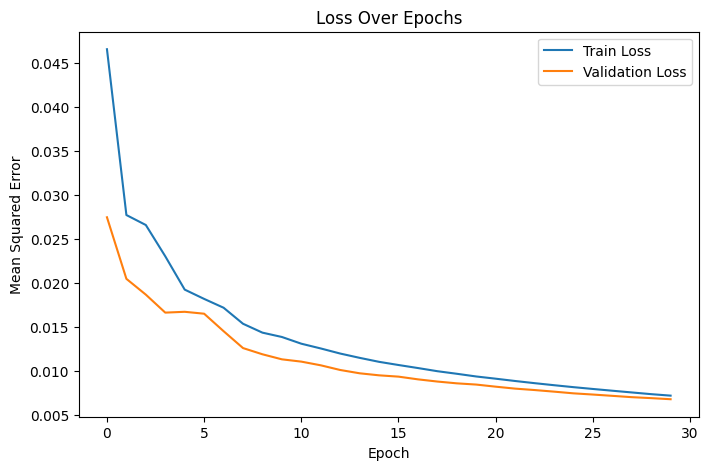

In [21]:
plot_history(picnn_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


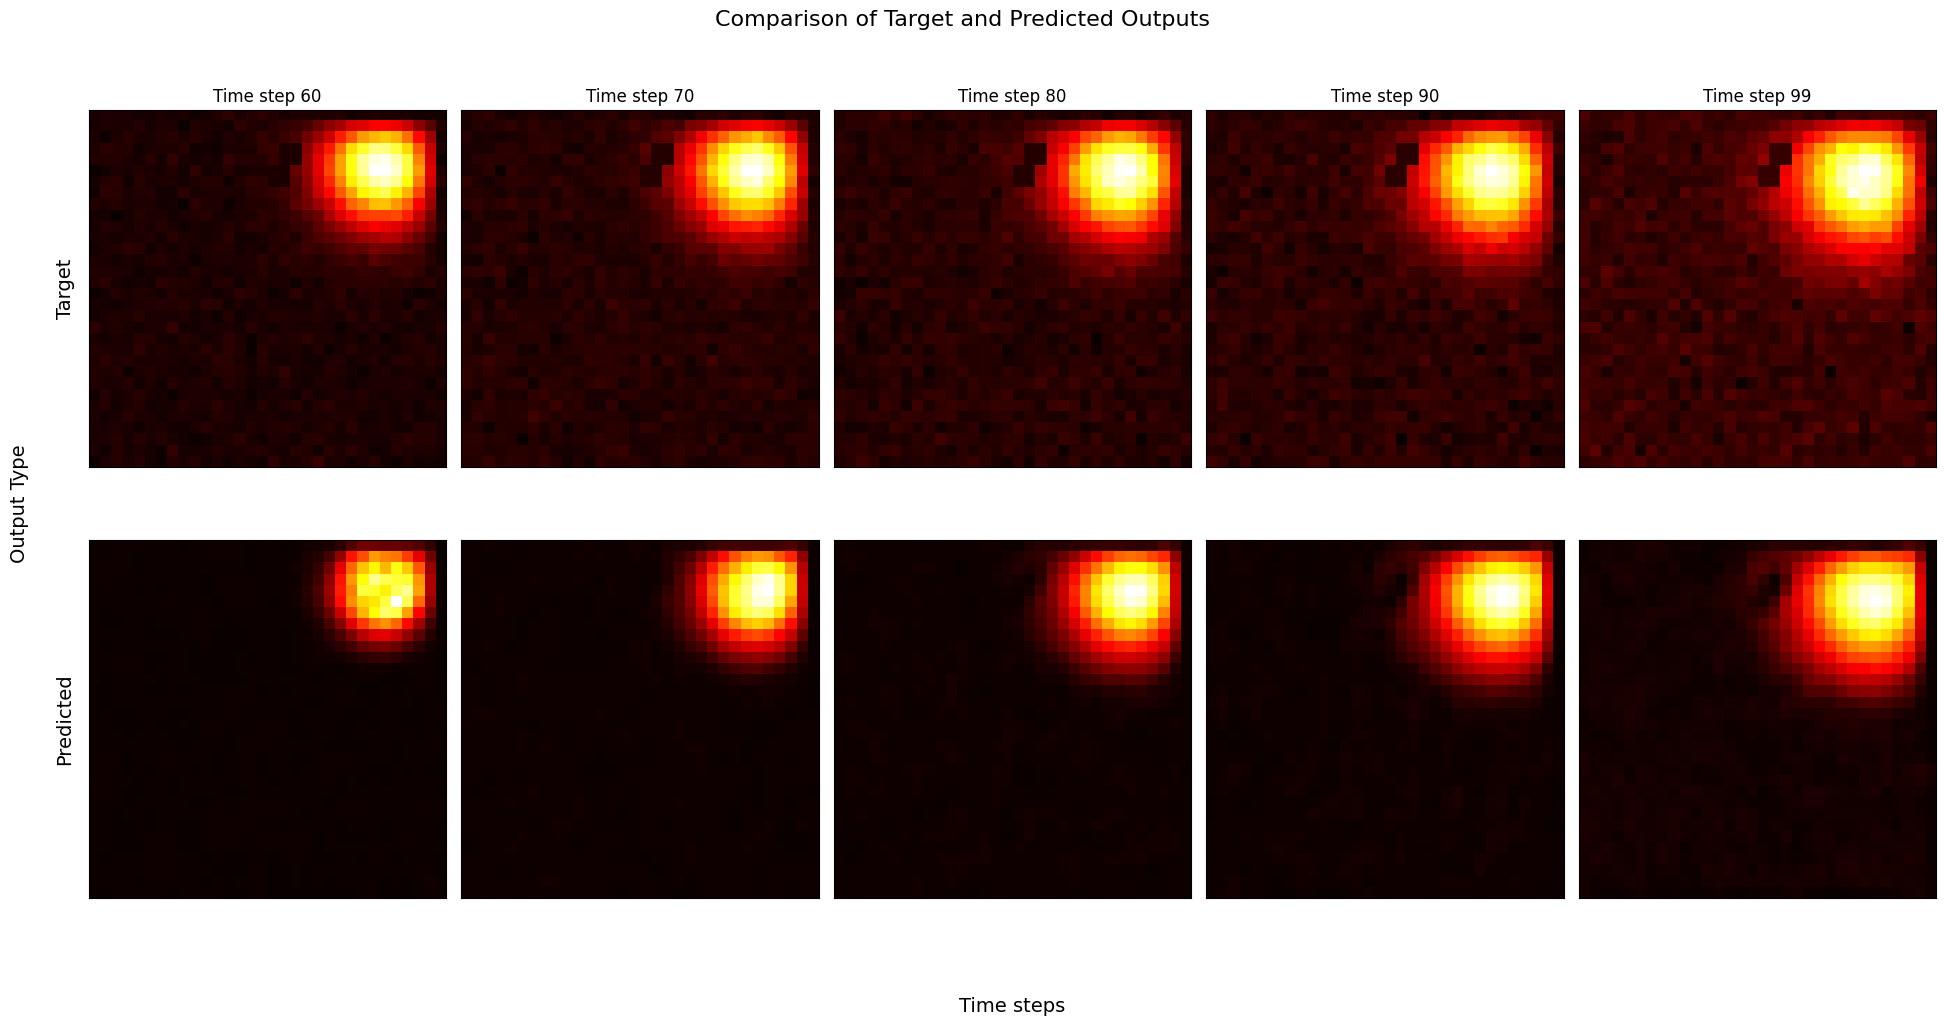

In [22]:
plot_comparison(picnn_model, val_data, val_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


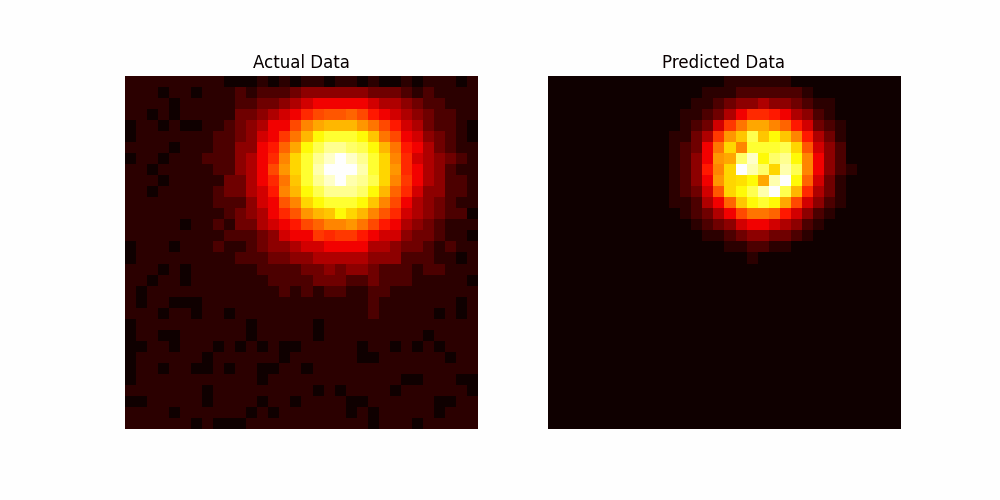

In [23]:
plot_comparison_as_gifs(picnn_model, val_data, val_labels)

## Improvement 3: Observational Bias -> preprocess data with heat diffusion equation

In [24]:
from scipy.signal import convolve2d
def diffusion_smoothing(data, alpha, iterations=1):
    # Define a diffusion kernel based on the alpha value
    kernel = np.array([[0, alpha, 0],
                       [alpha, 1 - 4 * alpha, alpha],
                       [0, alpha, 0]])
    

    smoothed_data = np.copy(data)
    for _ in range(iterations):
        for t in range(1, data.shape[1]-1):  # Avoid the first and last timestep to prevent boundary issues
            for sample in range(data.shape[0]):
                # Apply convolution to each 2D slice of each sample at each timestep
                for i in range(data.shape[4]): 
                    smoothed_data[sample, t, :, :, i] = convolve2d(smoothed_data[sample, t, :, :, i], kernel, mode='same', boundary='fill', fillvalue=0)
    
    return smoothed_data

In [25]:
cnn_model_2 = build_cnn(input_shape, output_shape)
cnn_model_2.compile(optimizer='adam', loss='mse')
train_data_smoothed = diffusion_smoothing(train_data, 0.1)
train_labels_smoothed = diffusion_smoothing(train_labels, 0.1)
cnn_history_2 = cnn_model_2.fit(train_data_smoothed, train_labels_smoothed, epochs=n_epochs, validation_data=(val_data, val_labels))

c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step - loss: 0.0256 - val_loss: 0.0106
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - loss: 0.0103 - val_loss: 0.0114
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - loss: 0.0110 - val_loss: 0.0093
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0084 - val_loss: 0.0065
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - loss: 0.0059 - val_loss: 0.0055
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - loss: 0.0037 - val_lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


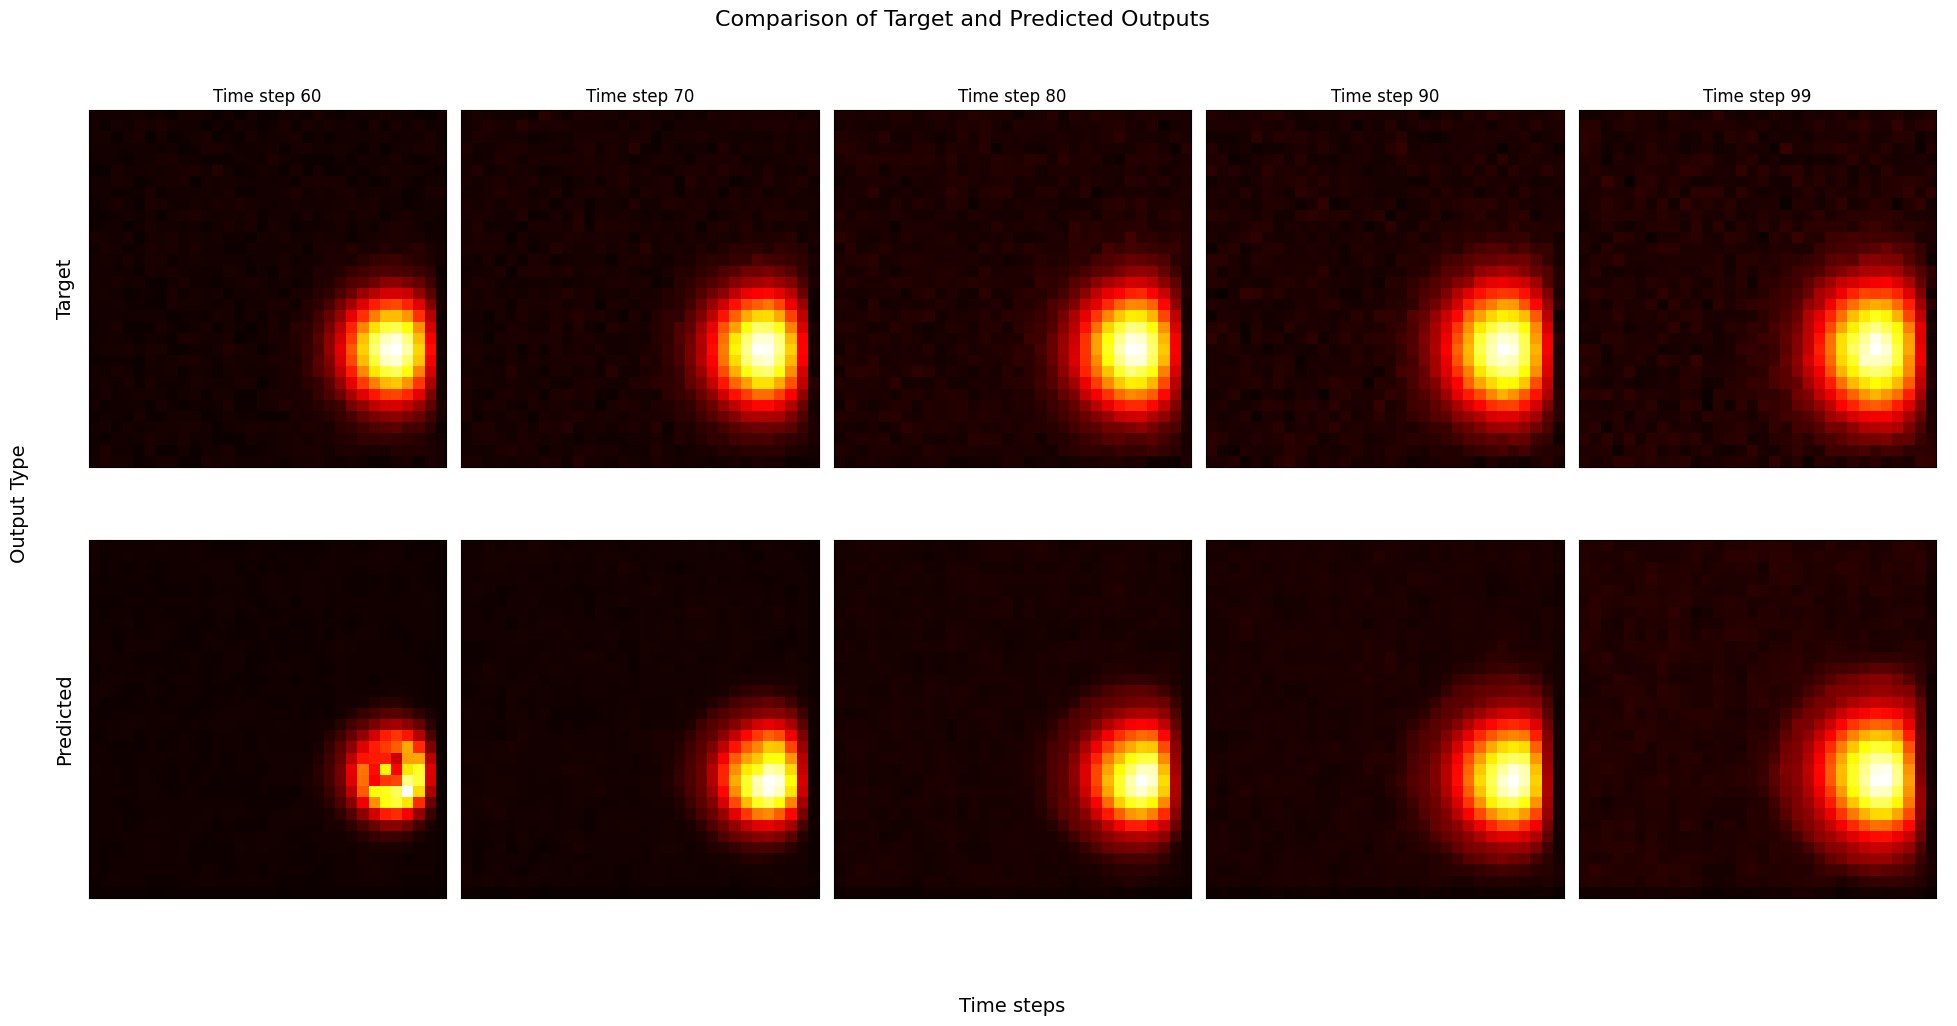

In [26]:
plot_comparison(cnn_model_2, val_data, val_labels)

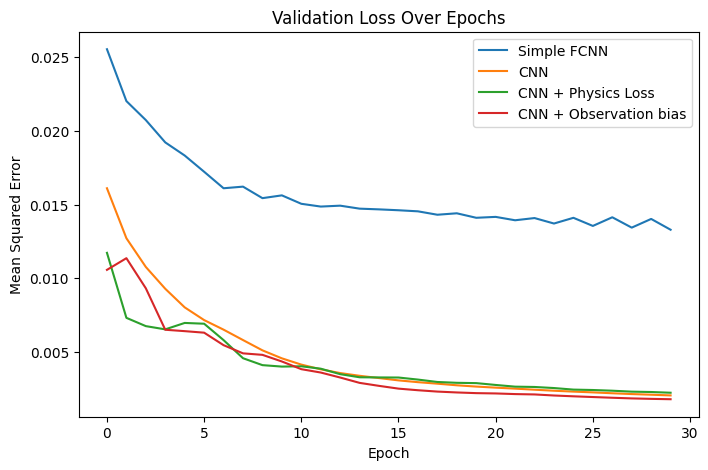

In [27]:
plot_model_comparison(fcnn_history, cnn_history, picnn_history, cnn_history_2)

## Considerations:
### Why use a CNN?
- Different possibilities to include time?
- how to design the CNN?

### What is our physics loss?
- What shoud we use?
- How do we choose the weights?
- When would the Laplacian be 0 in our example? Why does it still work?
- does adding physics informed loss work for the fully connected NN?

## Extra: FCNN with Learning Bias:

In [28]:
learning_fcnn_model = build_fcnn(input_shape, output_shape)

learning_fcnn_model.compile(optimizer='adam', loss=physics_informed_loss(w_l=1., w_p=1.0))
learing_fccn_history = learning_fcnn_model.fit(train_data, train_labels, epochs=n_epochs, validation_data=(val_data, val_labels))

Epoch 1/30


c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - loss: 0.0637 - val_loss: 0.0489
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0571 - val_loss: 0.0343
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0329 - val_loss: 0.0300
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0284 - val_loss: 0.0294
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0272 - val_loss: 0.0295
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0268 - val_loss: 0.0298
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0267 - val_loss: 0.0301
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0265 - val_loss: 0.0302
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0264 - val_loss: 0.0302
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0263 - val_loss: 0.0302
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0262 - val_loss: 0.0301
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0261 - val_loss: 0.0301
Epoch 13/30

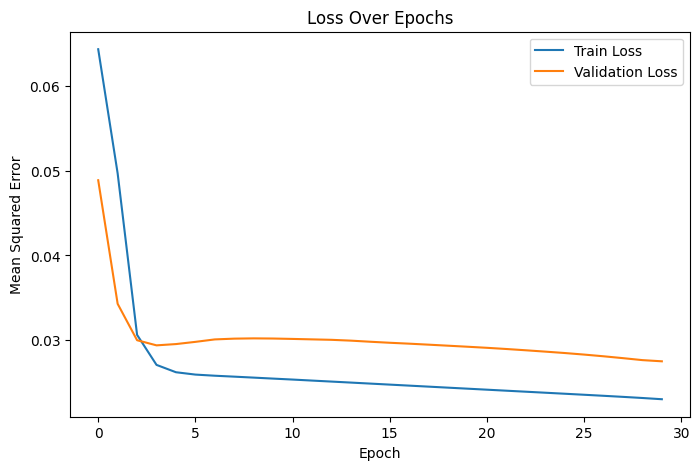

In [29]:
plot_history(learing_fccn_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


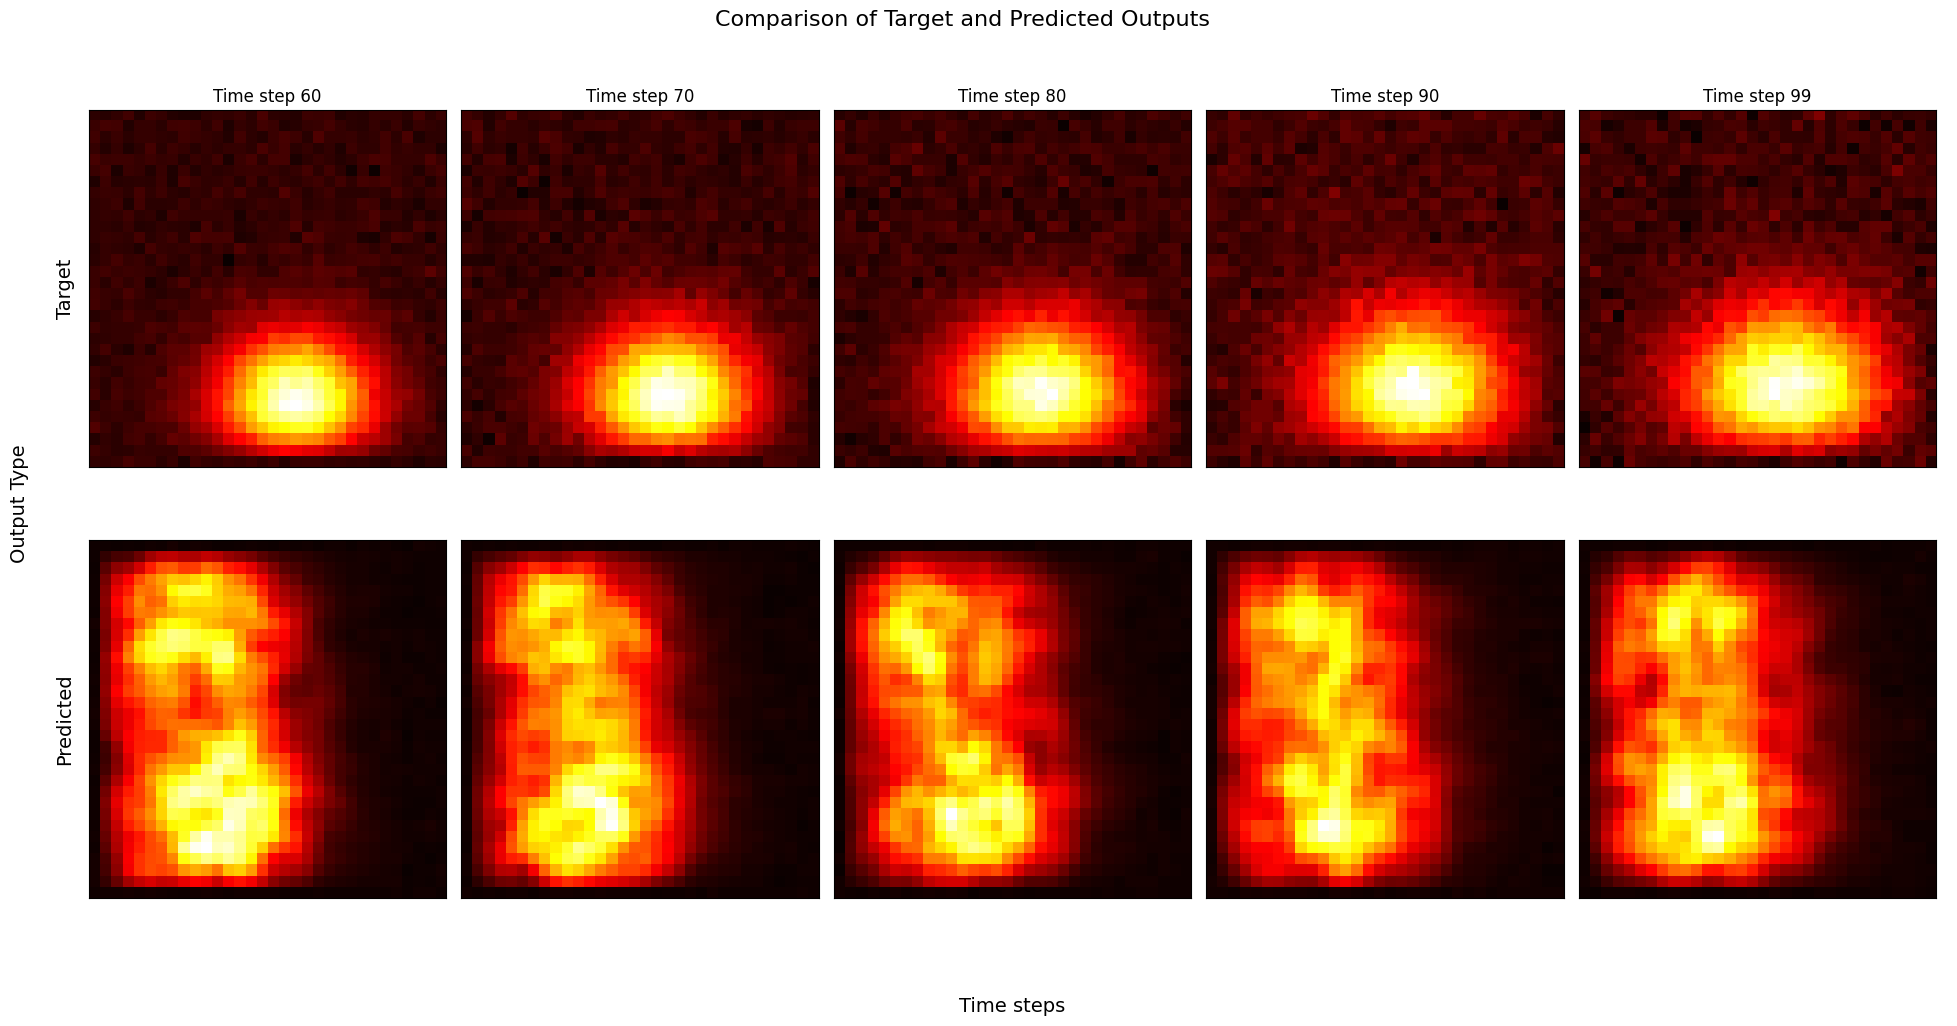

In [30]:
plot_comparison(learning_fcnn_model, val_data, val_labels)

## Model Comparison on validation data

In [31]:
# Assuming new_data and new_labels are your new dataset
evaluation_results = {}
models = [fcnn_model, cnn_model, picnn_model, cnn_model_2]  # List your models here
model_names = ["Simple FCNN", "CNN", "CNN + Physics Loss", "CNN + Observation bias"]

clean_val_data, _, _ = load_data('heat_diffusion_val_data_clean.npz')
clean_val_data = clean_val_data.reshape(clean_val_data.shape + (1,))
clean_val_labels = clean_val_data[:, 60:]
clean_val_data = clean_val_data[:, :60]

losses = []
losses.append(fcnn_model.evaluate(clean_val_data, clean_val_labels))
losses.append(cnn_model.evaluate(clean_val_data, clean_val_labels))
losses.append(picnn_model.evaluate(clean_val_data, clean_val_labels)[1])
losses.append(cnn_model_2.evaluate(clean_val_data, clean_val_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0130
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0019
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0055 - mse_metric: 0.0021 - physics_loss_metric: 0.0012
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0015


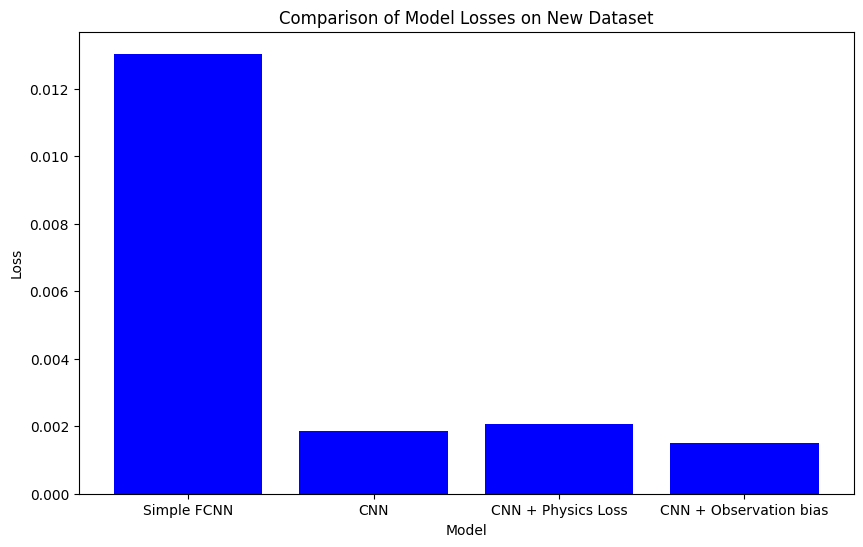

In [32]:
# Creating a bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, losses, color='blue')
plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Comparison of Model Losses on New Dataset')
plt.show()



## Observational bias smoothening

In [33]:

def plot_smoothing(data, alpha = 0.5, times=[0, 25, 50, 59]):
    data_idx = np.random.randint(0, data.shape[0])
    smooth_data = diffusion_smoothing(data, alpha)
    fig, axes = plt.subplots(2, len(times), figsize=(20, 10), squeeze=False)

    for i, time in enumerate(times):
        ax = axes[0, i]
        ax.imshow(data[data_idx][time], cmap='hot', interpolation='nearest')
    
    for i, time in enumerate(times):
        ax = axes[1, i]
        ax.imshow(smooth_data[data_idx][time], cmap='hot', interpolation='nearest')
    
    # Set time steps as x-labels at the bottom of the figure
    for i, time in enumerate(times):
        axes[-1, i].set_xlabel(f'Time step {time}', fontsize=12)
        axes[-1, i].xaxis.set_label_position('bottom')

    # Adjust layout to prevent overlapping and ensure everything fits
    plt.subplots_adjust(bottom=0.2, top=0.9, left=0.15, right=0.95, hspace=0.4, wspace=0.1)
    plt.show()

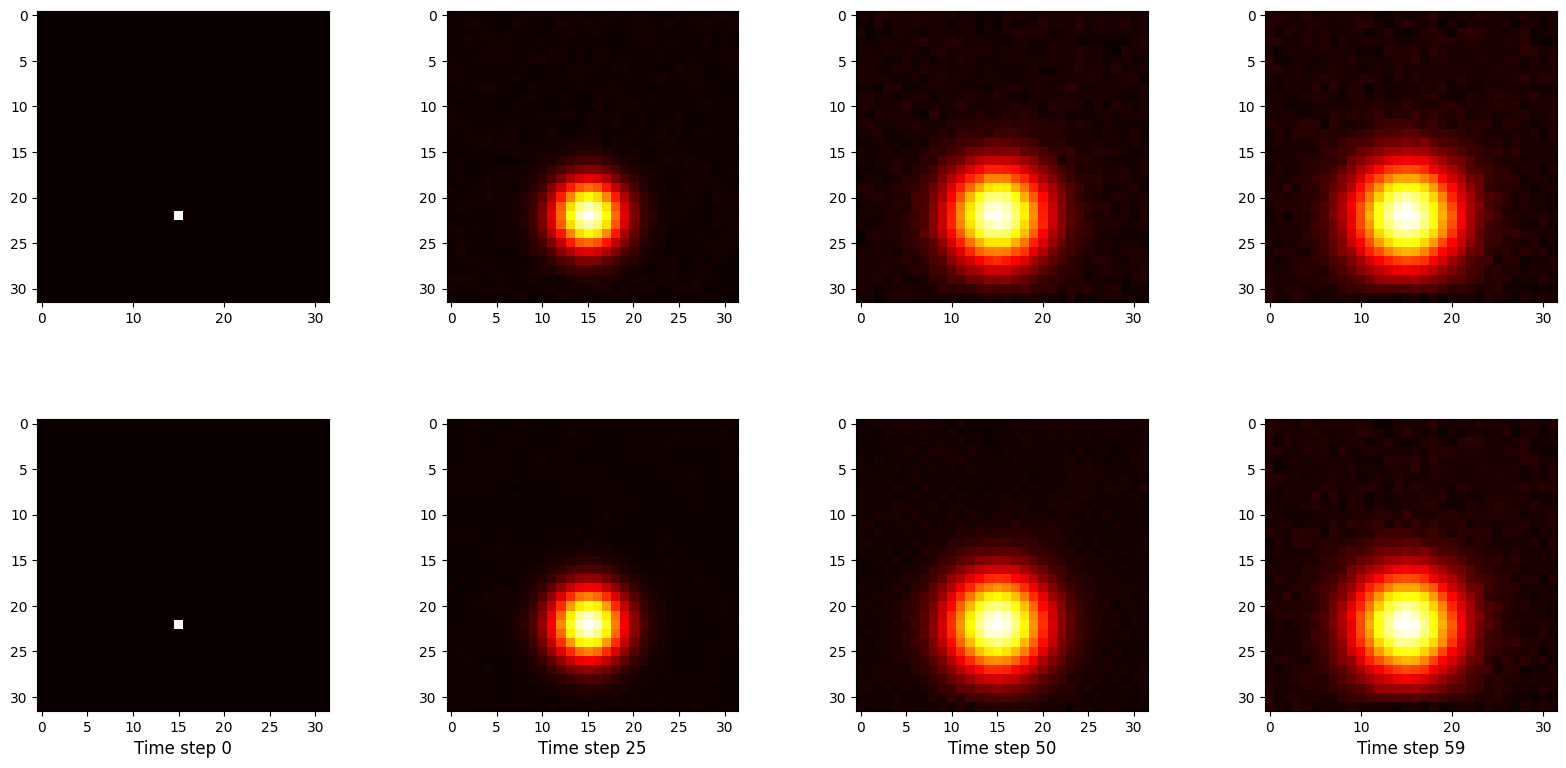

In [34]:
plot_smoothing(train_data, alpha=0.3)